In [1]:
import flopy
import matplotlib.pyplot as plt
import numpy as np

from shapely import geometry
from collections import namedtuple

In [2]:
# to remove the warnings shown in every cell
import warnings
warnings.filterwarnings('ignore')

In [3]:
Rectangle = namedtuple("Rectangle", "x y w h")

In [4]:
# Simulation parameters
X0 = 0
XN = 7800
NC = 78
ΔX = 7800/NC

Y0 = 0
YN = 4000
NR = 40
ΔY = 4000/NR

In [5]:
grid_points = np.mgrid[X0:XN+1:ΔX, Y0:YN+1:ΔY].reshape(2, -1).T
x_grids = np.linspace(X0, XN+1, NC)


In [6]:
def rect_2_poly(rect):
    "Convert custom Rectangle data to shapely Polygon."
    return geometry.Polygon([
        (rect.x, rect.y),
        (rect.x + rect.w, rect.y),
        (rect.x + rect.w, rect.y + rect.h),
        (rect.x, rect.y + rect.h),
    ])

In [7]:
domain = rect_2_poly(Rectangle(X0, Y0, XN, YN))
river = rect_2_poly(Rectangle(300, 0, 850, YN))
stream = rect_2_poly(Rectangle(6150, 0, 270, YN))
well = geometry.Point((5720, 2000))

In [8]:
def get_stress_period():
    "gives the stress_period_data on the grid_points"
    for i, gp in enumerate(grid_points):
        col = i // (NR+1)           # might have to swap these two.
        row = i % (NR+1)
        pt = geometry.Point(gp[0], gp[1])
        if river.contains(pt):
            yield (0, row, col), 10
        elif stream.contains(pt):
            yield (0, row, col), 10.5


In [21]:
sp = list(get_stress_period())
x = [l[0][2] for l in sp]
y = [l[0][1] for l in sp]


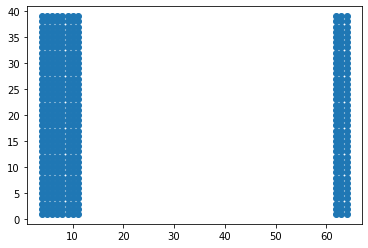

In [22]:
plt.scatter(x, y)
plt.show()

In [11]:
ws = './models/model-2'
name = 'model-2'

sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='modflow-mf6')

In [12]:
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)


In [13]:
dis = flopy.mf6.ModflowGwfdis(gwf,
                              nrow=NR,
                              ncol=NC,
                              delc=ΔX,
                              delr=ΔY,
                              top=15,
                              botm=15-220)

ic = flopy.mf6.ModflowGwfic(gwf)

In [14]:
recharge = flopy.mf6.ModflowGwfrcha(gwf, recharge=2)
npf = flopy.mf6.ModflowGwfnpf(gwf,
                              k=30,
                              save_specific_discharge=True)
chd = flopy.mf6.ModflowGwfchd(
    gwf,
    stress_period_data=(list(get_stress_period())))


In [15]:
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

In [16]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model model-2...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package rcha_0...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 429 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: /usr/local/bin/modflow-mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.2 07/30/2021

  MODFLOW 6 compiled Sep 19 2021 15:10:43 with GFORTRAN compiler (ver. 11.1.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to

(True, [])

In [17]:
head_arr = gwf.output.head().get_data()
bud = gwf.output.budget()


In [18]:
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)


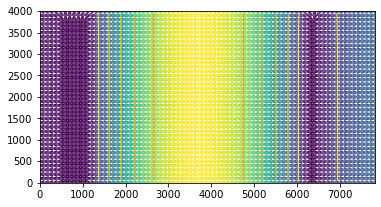

In [19]:
pmv = flopy.plot.PlotMapView(gwf)
pmv.plot_array(head_arr)
pmv.plot_grid(colors='white', linewidths=0.3)
pmv.contour_array(head_arr, linewidths=1., c_label=True, cmap='Wistia')
# flopy.plot.styles.graph_legend()
pmv.plot_vector(qx, qy, normalize=True, color="white")
plt.savefig(f"{ws}/plot.png")
plt.show()

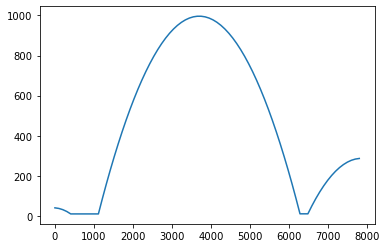

In [20]:
heads_xsection = head_arr[0][20]
plt.plot(x_grids, heads_xsection)
plt.show()